# BLR spatial model
I'm going to try to model the BLR clouds surrounding an AGN as in <i>Li et al. (2022): [SARM]: the Mass and Geometric Distance of the [SMBH] in the Quasar 3C 273</i>. I want to get a 2D map of an AGN with the surrounding clouds, each with a distance from- and angle around the center. There's also a $\theta$ dimension in their paper and I haven't yet worked out if that's relevant to implement?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_theme()
from scipy.special import gamma

## Radial distance models
First, their Dr1 model, describing a probability distribution as function of distance from the AGN. Takes parameters $F_{in}$, $R_{BLR}$, $\beta$, which are: Fraction of the mean BLR distance, mean BLR distance, and a shape parameter where $a = 1/\beta^2$ and $s = \beta^2 R_{BLR}$. These are equations (27), (28) from the paper.
$\begin{equation}
    P(r) = F_{in}R_{BLR} + (1-F_{in})\mathscr{R}(r, a, s)
\end{equation}$
$\begin{equation}
    \mathscr{R}(r, a, s) = \frac{r^{a-1}}{\Gamma(a)s^a}\exp\left(-\frac{x}{s}\right)
\end{equation}$
Where $\Gamma(a)$ is the gamma function. $\mathscr{R}$ is a gamma distribution.

In [2]:
def Dr1(r, R_BLR, beta, F_in=0.1):
    """Dr1 model from Li et al. 2022. A gamma distribution.

    Args:
        r (array): array of distances from the AGN
        R_BLR (float): mean BLR radius
        beta (float): non-zero shape parameter
        F_in (float): Inner edge fraction in units of R_BLR

    Returns:
        P(r) (array): Probability distribution of a BLR being at a certain distance from the central AGN
    """
    a = 1 / beta**2
    s = beta**2 * R_BLR
    
    R = r**(a-1) / (gamma(a) * s**a) * np.exp(-r/s)
    
    P = F_in*R_BLR + (1-F_in)*R 
    return P

C:\Users\Atlas\AppData\Local\Temp\ipykernel_23548\2574071530.py:16: RuntimeWarning: divide by zero encountered in power
  R = r**(a-1) / (gamma(a) * s**a) * np.exp(-r/s)


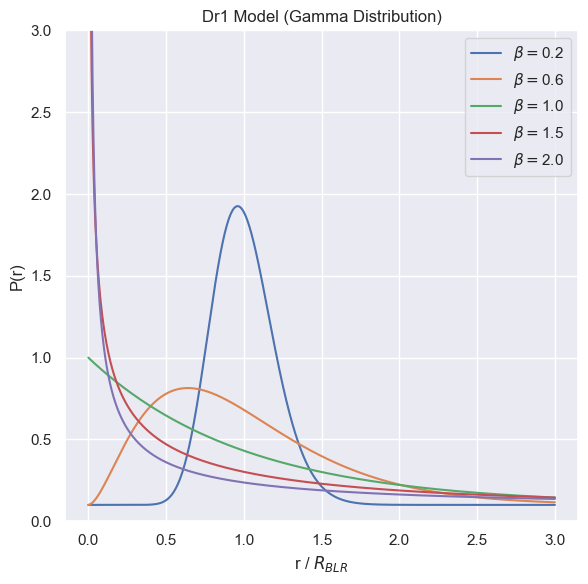

In [3]:
# Parameters
R_BLR = 1.0 # mean BLR radius
beta_values = [0.2, 0.6, 1.0, 1.5, 2.0]
F_in = 0.1 # fraction of R_BLR to the inner edge.
r = np.linspace(0, 3, 1000) * R_BLR 

# Plot Dr1 (Gamma Distribution)
plt.figure(figsize=(6, 6))
# plt.plot(r, np.ones_like(r)*F_in, '--', c='black', label=r'$F_{in} = $'+f'{F_in}') # just to show that the min. value is always going to be F_in
for beta in beta_values:
    P_r = Dr1(r, R_BLR, beta, F_in)
    plt.plot(r, P_r, label=r'$\beta = $'+f'{beta}')
plt.title('Dr1 Model (Gamma Distribution)')
plt.xlabel(r'r / $R_{BLR}$')
plt.ylabel('P(r)')
plt.tight_layout()
plt.ylim(0, 3)
plt.legend()
plt.show()

Now, Dr2: It's a piecewise function, each piece a powerlaw.

$\begin{equation} P(r) \propto \begin{cases} 
   (r/R_{BLR})^a & \text{for} F_{in}\leq r/R_{BLR} \leq 1, \\
   (r/R_{BLR})^{-\alpha} & \text{for} 1 < r/R_{BLR} \leq F_{out}
\end{cases}\end{equation}$
$\alpha$ is the slope of the powerlaw, $F_{in}$ and $F_{out}$ are fractions of $R_{BLR}$ parameterising the inner and outer radius of the BLRs.

In [4]:
def Dr2(r, R_BLR, alpha, F_in=0.1, F_out=1.):
    """Dr2 model from Li et al. 2022. A piecewise power-law function.

    Args:
        r (array): array of distances from the AGN
        R_BLR (float): mean BLR radius
        alpha (float): shape parameter
        F_in (float): Inner edge fraction in units of R_BLR
        F_out (float): Outer edge fraction in units of R_BLR

    Returns:
        P(r) (array): Probability distribution of a BLR being at a certain distance from the central AGN
    """
    ratio = r / R_BLR
    
    mask_inner = (F_in <= ratio) & (ratio <= 1)
    mask_outer = (1 <= ratio) & (ratio <= F_out)
    
    P = np.zeros_like(r)
    P[mask_inner] = ratio[mask_inner]**alpha
    P[mask_outer] = ratio[mask_outer]**-alpha
    
    return P

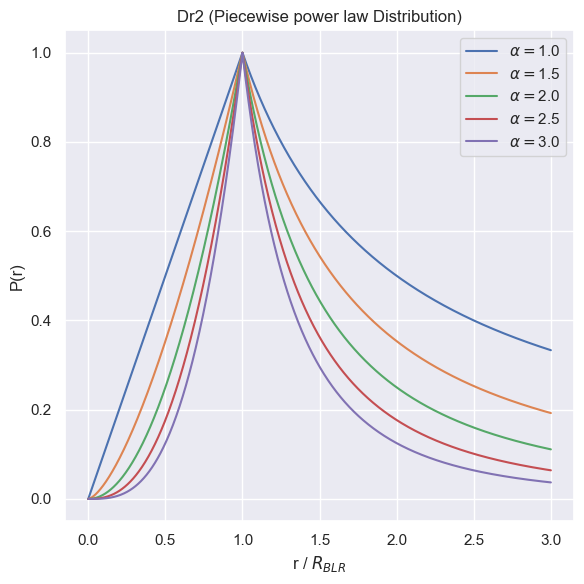

In [5]:
# Parameters
R_BLR = 1.0 # mean BLR radius
alpha_values = [1., 1.5, 2., 2.5, 3.]
F_in = 0.0 # fraction of R_BLR to the inner edge.
F_out = 3.0 # fraction of R_BLR to the outer edge (value must be outside max(r))
r = np.linspace(0, 3, 1000) * R_BLR 

# Plot Dr2 (Piecewise power law Distribution)
plt.figure(figsize=(6, 6))
# plt.plot(r, np.ones_like(r)*F_in, '--', c='black', label=r'$F_{in} = $'+f'{F_in}')
for alpha in alpha_values:
    P_r = Dr2(r, R_BLR, alpha, F_in, F_out)
    plt.plot(r, P_r, label=r'$\alpha = $'+f'{alpha}')
plt.title('Dr2 (Piecewise power law Distribution)')
plt.xlabel(r'r / $R_{BLR}$')
plt.ylabel('P(r)')
plt.tight_layout()
plt.legend()
plt.show()

So with this I have the probability distributions to draw from if I want to *place* a BLR at some distance from an AGN.

## $\theta$ angle models
Repeat but for the $\theta$ models. I really need to read *Pancoast et al. 2014a*. Anyway $D\theta1$:
$\begin{equation}
    \theta \propto \cos^{-1}[\cos\theta_{opn} + (1-\cos\theta_{opn})U^\gamma]
\end{equation}$
where $\gamma$ is a free parameter that controls the shape of the distribution. U is a uniformly distributed number between 0 and 1. The distribution density is then:
$\begin{equation}
    P(\theta) \propto \sin\theta(\cos\theta - \cos\theta_{opn})^{-\frac{\gamma-1}{\gamma}}
\end{equation}$

In [6]:
def Dtheta1(theta, theta_opn, gamma=1.):
    P = np.sin(theta) * (np.cos(theta) - np.cos(theta_opn))**(-(gamma-1)/gamma)
    return P

C:\Users\Atlas\AppData\Local\Temp\ipykernel_23548\1391852783.py:2: RuntimeWarning: divide by zero encountered in power
  P = np.sin(theta) * (np.cos(theta) - np.cos(theta_opn))**(-(gamma-1)/gamma)


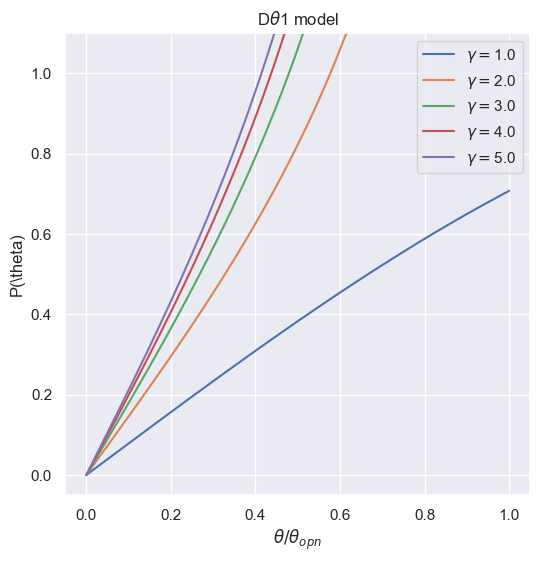

In [7]:
theta_opn = np.pi/4 # opening angle of the BLR distribution. yeap
gamma_values = [1., 2., 3., 4., 5.]
theta = np.linspace(0, theta_opn, 1000)

plt.figure(figsize=(6, 6))
for gamma in gamma_values:
    P_theta = Dtheta1(theta, theta_opn, gamma)
    plt.plot(theta/theta_opn, P_theta, label=r'$\gamma = $'+f'{gamma}')
plt.title(r'$D\theta1$ model')
plt.xlabel(r'$\theta/\theta_{opn}$')
plt.ylabel(r'$P(\theta)$')
plt.ylim(-0.05, 1.1)
plt.legend()
plt.show()

For $D\theta2$:
$\begin{equation}
    \theta \propto \theta_{opn}(1-U^\frac{1}{\gamma})
\end{equation}$
where $\gamma$ is a free parameter that controls the shape of the distribution. U is a uniformly distributed number between 0 and 1. The distribution density is then:
$\begin{equation}
    P(\theta) \propto (1-\theta/theta_{opn})^{\gamma-1}
\end{equation}$

In [8]:
def Dtheta2(theta, theta_opn, gamma=1.):
    P = (1-theta/theta_opn)**(gamma-1)
    return P

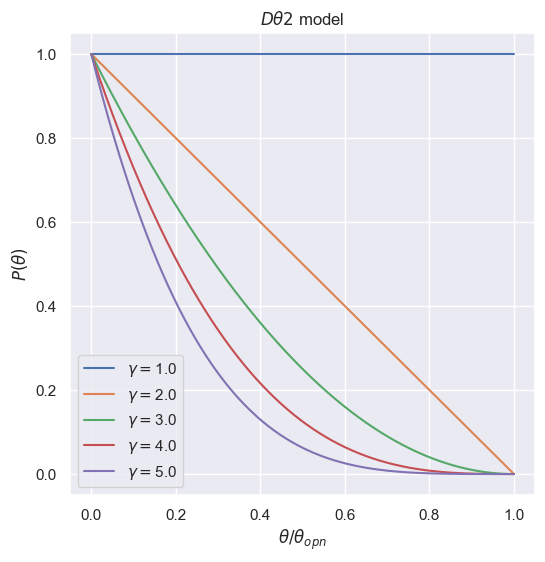

In [14]:
theta_opn = np.pi/4 # opening angle of the BLR distribution. yeap
gamma_values = [1., 2., 3., 4., 5.]
theta = np.linspace(0, theta_opn, 1000)

plt.figure(figsize=(6, 6))
for gamma in gamma_values:
    P_theta = Dtheta2(theta, theta_opn, gamma)
    plt.plot(theta/theta_opn, P_theta, label=r'$\gamma = $'+f'{gamma}')
plt.title(r'$D\theta2$ model')
plt.xlabel(r'$\theta/\theta_{opn}$')
plt.ylabel(r'$P(\theta)$')
plt.legend()
plt.show()

Brb reading Pancoast et al. 2014a.